In [2]:
# system level
import sys
import json
import codecs
import os
# arrays
import numpy as np
from numpy import random
from scipy import interp

import astropy
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

# keras
from keras import backend as K
from keras import models
from keras.models import Sequential, Model
from keras.models import model_from_json
from keras.layers import Input, Flatten, Dense, Activation, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.utils import np_utils

import tensorflow as tf
# sklearn (for machine learning)
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split

# plotting
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import seaborn as sns
import matplotlib.patches as mpatches

# grad-CAM
from vis.visualization import visualize_cam
from vis.utils import utils

Using TensorFlow backend.


In [3]:
%%time
file_url = 'https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-noisy.fits'
hdu = fits.open(download_file(file_url, cache=True, show_progress=True))

CPU times: user 908 µs, sys: 800 µs, total: 1.71 ms
Wall time: 1.65 ms


In [3]:
# print(hdu[0].data) - image data
hdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                   75                                                  
NAXIS2  =                   75                                                  
NAXIS3  =                    3                                                  
NAXIS4  =                15426                                                  
EXTEND  =                    T                                                  
NAME1   = 'ImageX  '                                                            
NAME2   = 'ImageY  '                                                            
NAME3   = 'filter  '           / F814W,F356W,F160W                              
NAME4   = 'object  '                                                            
EXTNAME = 'Images  '        

In [4]:
print(hdu[1].data)
hdu[1].header

[(1.,) (1.,) (1.,) ... (0.,) (0.,) (0.,)]


XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                    8 / length of dimension 1                          
NAXIS2  =                15426 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    1 / number of table fields                         
TTYPE1  = 'MergerLabel'                                                         
TFORM1  = 'D       '                                                            
EXTNAME = 'MergerLabel'                                                         

In [5]:
hdu[0].data.shape

(15426, 3, 75, 75)

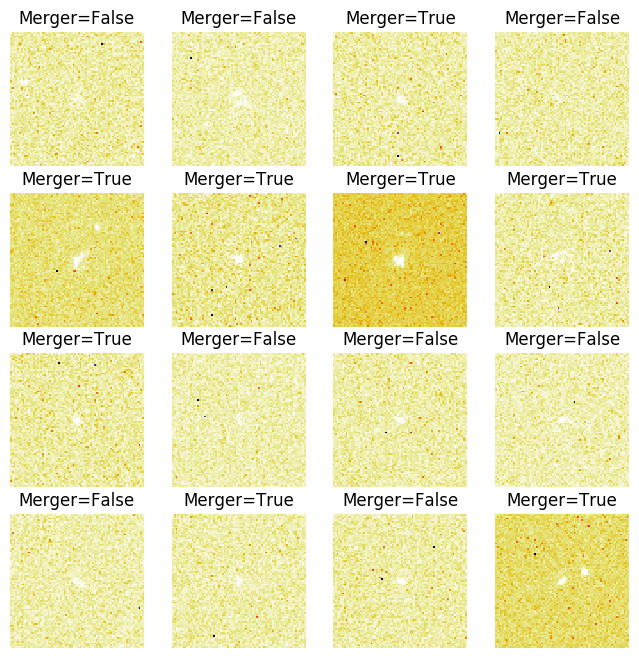

In [18]:
# set the random seed to get the same random set of images each time, or comment it out to get different ones!
# np.random.seed(206265)

# select 16 random image indices:
example_ids = np.random.choice(hdu[1].data.shape[0], 16)
# pull the F160W image (index=1) from the simulated dataset for these selections
examples = [hdu[0].data[j, 1, :, :] for j in example_ids]

# initialize your figure
fig = plt.figure(figsize=(8, 8)) 

# loop through the randomly selected images and plot with labels
for i, image in enumerate(examples):
    ax = fig.add_subplot(4, 4, i+1)
    norm = simple_norm(image, 'log', max_percent=99.75)

    ax.imshow(image, aspect='equal', cmap='CMRmap', norm=norm)
    ax.set_title('Merger='+str(bool(hdu[1].data[example_ids[i]][0])))
    
    ax.axis('off')
    
plt.show()

In [7]:
X = hdu[0].data
y = hdu[1].data

In [8]:
# as above, set the random seed to randomly split the images in a repeatable way. Feel free to try different values!
random_state = 100 #Originally 42

X = np.asarray(X).astype('float32')
y = np.asarray(y).astype('float32')

# First split off 30% of the data for validation+testing
X_train, X_split, y_train, y_split = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=True)

# Then divide this subset into training and testing sets: 20% (testing) + 10% (validation) = 30%
X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, test_size=0.666, random_state=random_state, shuffle=True)

In [9]:
imsize = np.shape(X_train)[2]

X_train = X_train.reshape(-1, imsize, imsize, 3)
X_valid = X_valid.reshape(-1, imsize, imsize, 3)
X_test = X_test.reshape(-1, imsize, imsize, 3)

In [10]:
# ------------------------------------------------------------------------------
# generate the model architecture
# Written for Keras 2
# ------------------------------------------------------------------------------

# Define architecture for model
data_shape = np.shape(X)
input_shape = (imsize, imsize, 3)

x_in = Input(shape=input_shape)
c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
e0 = Dropout(0.5)(d0)

c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
e1 = Dropout(0.5)(d1)

c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
e2 = Dropout(0.5)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
y_out = Dense(1, activation='sigmoid')(z1)

cnn = Model(inputs=x_in, outputs=y_out)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2024-12-16 11:17:22.101535: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2024-12-16 11:17:22.104711: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2496000000 Hz
2024-12-16 11:17:22.105041: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x631d79f2ccd0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-12-16 11:17:22.105055: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-12-16 11:17:22.106981: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-12-16 11:17:22.120313: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-12-16 11:17:22.120335: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156]

In [11]:
# Compile Model
optimizer = 'adam'
fit_metrics = ['accuracy']
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)
cnn.summary()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 8)         608       
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 8)         32        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 37, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 16)        1168      
_____________________________

In [13]:
nb_epoch = 500
batch_size = 128 #Originally 128
shuffle = True

# Train
history = cnn.fit(X_train, y_train, 
                  batch_size=batch_size, 
                  epochs=nb_epoch, 
                  validation_data=(X_valid, y_valid),
                  shuffle=shuffle,
                  verbose=False)

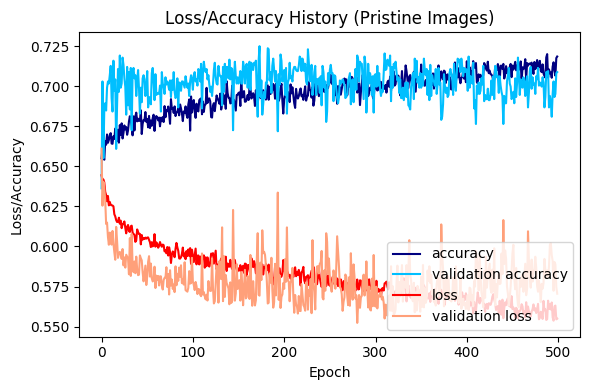

In [14]:
# plotting from history
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = list(range(len(loss)))

figsize = (6, 4)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'deepskyblue', label="validation accuracy")

plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="validation loss")


plots = plot1_loss + plot1_val_loss
labs = [plot.get_label() for plot in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Loss/Accuracy History (Pristine Images)")
plt.tight_layout()
axis1.legend(loc='lower right')
plt.show()

In [15]:
test_predictions = cnn.predict(X_test)

In [16]:
def plot_confusion_matrix(cnn, input_data, input_labels):
    
    # Compute merger predictions for the test dataset
    predictions = cnn.predict(input_data)

    # Convert to binary classification 
    predictions = (predictions > 0.5).astype('int32') 
    
    # Compute the confusion matrix by comparing the test labels (ds.test_labels) with the test predictions
    cm = metrics.confusion_matrix(input_labels, predictions, labels=[0, 1])
    cm = cm.astype('float')

    # Normalize the confusion matrix results. 
    cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
    
    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.matshow(cm_norm, cmap='binary_r', aspect='auto')

    plt.title('Confusion matrix', y=1.08)
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Merger', 'No Merger'])
    
    ax.set_ylim(0, 1)
    ax.set_yticks([0.25, 0.75])
    ax.set_yticklabels(['Merger', 'No Merger'])

    plt.xlabel('Predicted')
    plt.ylabel('True')

    fmt = '.2f'
    thresh = cm_norm.max() / 2.
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            if i==0:
                ax.text(j, i+0.25, format(cm_norm[i, j], fmt), ha="center", color="white" if cm_norm[i, j] < thresh else "black")
            else:
                ax.text(j, i-0.25, format(cm_norm[i, j], fmt), ha="center", color="white" if cm_norm[i, j] < thresh else "black")
    plt.show()

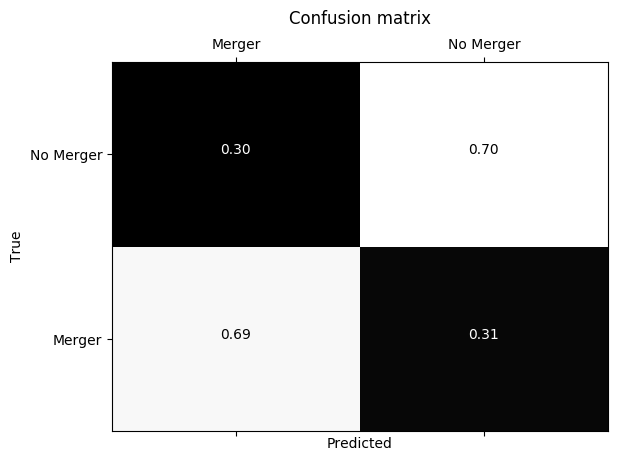

In [17]:
plot_confusion_matrix(cnn, X_test, y_test)